https://www.kaggle.com/thomasnelson/working-with-dna-sequence-data-for-ml

In [326]:
from Bio import SeqIO
from tqdm import tqdm, tqdm_notebook

from pathlib import Path

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook

In [327]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [328]:
random_state = 4

In [329]:
sg_reads_seq = []
sg_reads_tax = []

for seq_record in SeqIO.parse('data/16S-SG-reads.fa/16S-reads.fa', "fasta"):
    sg_reads_seq.append(seq_record.seq)
    sg_reads_tax.append(seq_record.description[seq_record.description.find('description=')+12+1:-1].split())
    
len(sg_reads_seq), len(sg_reads_tax)

(28224, 28224)

In [332]:
print(sg_reads_seq[0])

GCCCCGGGCTCAACCTGGGAACTGCATTTCGAACTGGCAAACTAGAGTTCTTGAGAGGGTGGTAGAATTTCAGGTGTAGCGGTGAAATGCGAAGAGATCTGAAGGATTACCAGTGGCGAAGGCGGCCTACCGGCAACTATCCGACTCTCGGATGCGAAAGCGAGGTACCGGACGGGATCCGTTGAGCTGTATTTGCCCGCGGTAAATGGATTCCGCTAGCGGGACTCGGAGAGCCTTAGTGGAACCAC


In [333]:
print(sg_reads_tax[0])

['Gammaproteobacteria', 'Alteromonadales', 'Moritellaceae', 'Moritella']


# Class

In [15]:
import numpy as np
import pandas as pd

tax = ["Class", "Order", "Family", "Genus"]

sg = pd.DataFrame()

col = []
for j in sg_reads_tax:
    col.append(j[0])
sg[tax[0]] = col

#pd.get_dummies() always arrange the different categories in alphabetical order and then assign values
pd.get_dummies(sg)

,Class_Alphaproteobacteria,Class_Betaproteobacteria,Class_Gammaproteobacteria
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1
...,...,...,...
28219,0,0,1
28220,0,0,1
28221,1,0,0
28222,1,0,0


In [121]:
sg

,Class
0,Gammaproteobacteria
1,Alphaproteobacteria
2,Gammaproteobacteria
3,Alphaproteobacteria
4,Gammaproteobacteria
...,...
28219,Gammaproteobacteria
28220,Gammaproteobacteria
28221,Alphaproteobacteria
28222,Alphaproteobacteria


In [16]:
classes = list(pd.get_dummies(sg).columns)
labels = np.argmax(np.array(pd.get_dummies(sg)), axis=1)
print(labels, len(labels))

min([len(k) for k in sg_reads_seq]), max([len(k) for k in sg_reads_seq])

[2 0 2 ... 0 0 2] 28224


(229, 274)

In [24]:
sg_reads_seq[0], type(sg_reads_seq[0])

(Seq('GCCCCGGGCTCAACCTGGGAACTGCATTTCGAACTGGCAAACTAGAGTTCTTGA...CAC'),
 Bio.Seq.Seq)

# Encoding

In [35]:
# function to convert a DNA sequence string to a numpy array
# converts to lower case, changes any non 'acgt' characters to 'n'
import numpy as np
import re
def string_to_array(my_string):
    my_string = my_string.lower()
    my_string = re.sub('[^acgt]', 'z', my_string)
    my_array = np.array(list(my_string))
    return my_array

## Ordinal encoding DNA sequence data


In [36]:
# create a label encoder with 'acgtn' alphabet
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

LabelEncoder()

In [37]:
string_to_array(str(sg_reads_seq[0]))

array(['g', 'c', 'c', 'c', 'c', 'g', 'g', 'g', 'c', 't', 'c', 'a', 'a',
       'c', 'c', 't', 'g', 'g', 'g', 'a', 'a', 'c', 't', 'g', 'c', 'a',
       't', 't', 't', 'c', 'g', 'a', 'a', 'c', 't', 'g', 'g', 'c', 'a',
       'a', 'a', 'c', 't', 'a', 'g', 'a', 'g', 't', 't', 'c', 't', 't',
       'g', 'a', 'g', 'a', 'g', 'g', 'g', 't', 'g', 'g', 't', 'a', 'g',
       'a', 'a', 't', 't', 't', 'c', 'a', 'g', 'g', 't', 'g', 't', 'a',
       'g', 'c', 'g', 'g', 't', 'g', 'a', 'a', 'a', 't', 'g', 'c', 'g',
       'a', 'a', 'g', 'a', 'g', 'a', 't', 'c', 't', 'g', 'a', 'a', 'g',
       'g', 'a', 't', 't', 'a', 'c', 'c', 'a', 'g', 't', 'g', 'g', 'c',
       'g', 'a', 'a', 'g', 'g', 'c', 'g', 'g', 'c', 'c', 't', 'a', 'c',
       'c', 'g', 'g', 'c', 'a', 'a', 'c', 't', 'a', 't', 'c', 'c', 'g',
       'a', 'c', 't', 'c', 't', 'c', 'g', 'g', 'a', 't', 'g', 'c', 'g',
       'a', 'a', 'a', 'g', 'c', 'g', 'a', 'g', 'g', 't', 'a', 'c', 'c',
       'g', 'g', 'a', 'c', 'g', 'g', 'g', 'a', 't', 'c', 'c', 'g

In [38]:
# function to encode a DNA sequence string as an ordinal vector
# returns a numpy vector with a=0.25, c=0.50, g=0.75, t=1.00, n=0.00
def ordinal_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25 # A
    float_encoded[float_encoded == 1] = 0.50 # C
    float_encoded[float_encoded == 2] = 0.75 # G
    float_encoded[float_encoded == 3] = 1.00 # T
    float_encoded[float_encoded == 4] = 0.00 # anything else, z
    return float_encoded

In [39]:
test_sequence = 'AACGCGCTTNNW'
ordinal_encoder(string_to_array(test_sequence))

array([0.25, 0.25, 0.5 , 0.75, 0.5 , 0.75, 0.5 , 1.  , 1.  , 0.  , 0.  ,
       0.  ])

## One-hot encoding DNA sequence data

In [40]:
# function to one-hot encode a DNA sequence string
# non 'acgt' bases (n) are 0000
# returns a L x 4 numpy array
from sklearn.preprocessing import OneHotEncoder
def one_hot_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)#, n_values=5)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded

In [41]:
test_sequence = 'AACGCGGTTNN'
one_hot_encoder(string_to_array(test_sequence))

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

# k-mer counting

In [47]:
def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [48]:
mySeq = 'CATGGCCATCCCCCCCCGAGCGGGGGGGGGG'
getKmers(mySeq, size=6)

['catggc',
 'atggcc',
 'tggcca',
 'ggccat',
 'gccatc',
 'ccatcc',
 'catccc',
 'atcccc',
 'tccccc',
 'cccccc',
 'cccccc',
 'cccccc',
 'cccccg',
 'ccccga',
 'cccgag',
 'ccgagc',
 'cgagcg',
 'gagcgg',
 'agcggg',
 'gcgggg',
 'cggggg',
 'gggggg',
 'gggggg',
 'gggggg',
 'gggggg',
 'gggggg',
 'ggggg']

In [46]:
words = getKmers(mySeq, size=6)
sentence = ' '.join(words)
sentence

'catggc atggcc tggcca ggccat gccatc ccatcc catccc atcccc tccccc cccccc cccccc cccccc cccccg ccccga cccgag ccgagc cgagcg gagcgg agcggg gcgggg cggggg gggggg gggggg gggggg gggggg gggggg'

You can tune both the word length and the amount of overlap. This allows you to determine how sequence information and vocabulary size will be important in your application. For example, if you use words of length 6, and there are 4 letters, you have a vocabulary of size 4096 possible words. You can then go on and create a bag-of-words model like you would in NLP.

In [49]:
mySeq2 = 'GATGGCCATCCCCGCCCGAGCGGGGGGGG'
mySeq3 = 'CATGGCCATCCCCGCCCGAGCGGGCGGGG'
sentence2 = ' '.join(getKmers(mySeq2, size=6))
sentence3 = ' '.join(getKmers(mySeq3, size=6))

In [53]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform([sentence, sentence2, sentence3]).toarray()

In [54]:
cv.vocabulary_

{'catggc': 4,
 'atggcc': 2,
 'tggcca': 32,
 'ggccat': 25,
 'gccatc': 21,
 'ccatcc': 5,
 'catccc': 3,
 'atcccc': 1,
 'tccccc': 30,
 'cccccc': 6,
 'cccccg': 7,
 'ccccga': 8,
 'cccgag': 10,
 'ccgagc': 12,
 'cgagcg': 14,
 'gagcgg': 19,
 'agcggg': 0,
 'gcgggg': 24,
 'cggggg': 18,
 'gggggg': 29,
 'gatggc': 20,
 'tccccg': 31,
 'ccccgc': 9,
 'cccgcc': 11,
 'ccgccc': 13,
 'cgcccg': 15,
 'gcccga': 22,
 'ggggg': 28,
 'gcgggc': 23,
 'cgggcg': 16,
 'gggcgg': 27,
 'ggcggg': 26,
 'cgggg': 17}

Presumably you'll have many sequences that get encoded and will have a large vocabulary size. In this example I am only using 3 short sequences, so we have just a few words in our vocabulary. In the end you will have uniform length numerical vectors that can be fed into various machine learning or deep learning algorithms. Here you can see the bag-of-words returns counts of hexamers in the vocabulary.

In [55]:
X

array([[1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 5, 1, 0, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 3, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]], dtype=int64)

# Working with DNA sequence data for ML part 2
https://www.kaggle.com/thomasnelson/working-with-dna-sequence-data-for-ml-part-2

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [58]:
sg_reads_seq[0], labels

(Seq('GCCCCGGGCTCAACCTGGGAACTGCATTTCGAACTGGCAAACTAGAGTTCTTGA...CAC'),
 array([2, 0, 2, ..., 0, 0, 2], dtype=int64))

In [65]:
human = pd.DataFrame()
human['sequence'] = [str(i) for i in sg_reads_seq]
human['class'] = labels

In [66]:
human.head()

,sequence,class
0,GCCCCGGGCTCAACCTGGGAACTGCATTTCGAACTGGCAAACTAGA...,2
1,ACTGCCTCCAAAACTATCAGTCTAGAGTTCGAGAGAGGTGAGTGGA...,0
2,TAGCGGCGTCGTTTGACGTTAGCGACAGAAGAAGCACCGGCTAACT...,2
3,CTAGCGTTGTTCGGAATTACTGGGCGTATAGCGCGCGTTAGGCGGA...,0
4,CATGGCTCAGATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTC...,2


In [67]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [68]:
human['words'] = human.apply(lambda x: getKmers(x['sequence']), axis=1)
human = human.drop('sequence', axis=1)

In [69]:
human.head()

,class,words
0,2,"[gccccg, ccccgg, cccggg, ccgggc, cgggct, gggct..."
1,0,"[actgcc, ctgcct, tgcctc, gcctcc, cctcca, ctcca..."
2,2,"[tagcgg, agcggc, gcggcg, cggcgt, ggcgtc, gcgtc..."
3,0,"[ctagcg, tagcgt, agcgtt, gcgttg, cgttgt, gttgt..."
4,2,"[catggc, atggct, tggctc, ggctca, gctcag, ctcag..."


Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use. We can also make a y variable to hold the class labels. Let's do that now.

In [73]:
human_texts = list(human['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_h = human.iloc[:, 0].values   

In [76]:
human_texts[0]

'gccccg ccccgg cccggg ccgggc cgggct gggctc ggctca gctcaa ctcaac tcaacc caacct aacctg acctgg cctggg ctggga tgggaa gggaac ggaact gaactg aactgc actgca ctgcat tgcatt gcattt catttc atttcg tttcga ttcgaa tcgaac cgaact gaactg aactgg actggc ctggca tggcaa ggcaaa gcaaac caaact aaacta aactag actaga ctagag tagagt agagtt gagttc agttct gttctt ttcttg tcttga cttgag ttgaga tgagag gagagg agaggg gagggt agggtg gggtgg ggtggt gtggta tggtag ggtaga gtagaa tagaat agaatt gaattt aatttc atttca tttcag ttcagg tcaggt caggtg aggtgt ggtgta gtgtag tgtagc gtagcg tagcgg agcggt gcggtg cggtga ggtgaa gtgaaa tgaaat gaaatg aaatgc aatgcg atgcga tgcgaa gcgaag cgaaga gaagag aagaga agagat gagatc agatct gatctg atctga tctgaa ctgaag tgaagg gaagga aaggat aggatt ggatta gattac attacc ttacca taccag accagt ccagtg cagtgg agtggc gtggcg tggcga ggcgaa gcgaag cgaagg gaaggc aaggcg aggcgg ggcggc gcggcc cggcct ggccta gcctac cctacc ctaccg taccgg accggc ccggca cggcaa ggcaac gcaact caacta aactat actatc ctatcc tatccg atccga tccgac ccgact cgactc gactc

In [77]:
y_h

array([2, 0, 2, ..., 0, 0, 2], dtype=int64)

Now let's review how to use sklearn's "Natural Language" Processing tools to convert our k-mer words into uniform length numerical vectors that represent counts for every k-mer in the vocabulary.

In [88]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)

In [89]:
X.shape

(28224, 272193)

In [90]:
cv.vocabulary_

{'gccccg ccccgg cccggg ccgggc': 157785,
 'ccccgg cccggg ccgggc cgggct': 90258,
 'cccggg ccgggc cgggct gggctc': 91289,
 'ccgggc cgggct gggctc ggctca': 95447,
 'cgggct gggctc ggctca gctcaa': 112143,
 'gggctc ggctca gctcaa ctcaac': 179495,
 'ggctca gctcaa ctcaac tcaacc': 176760,
 'gctcaa ctcaac tcaacc caacct': 165902,
 'ctcaac tcaacc caacct aacctg': 122578,
 'tcaacc caacct aacctg acctgg': 221661,
 'caacct aacctg acctgg cctggg': 69159,
 'aacctg acctgg cctggg ctggga': 6164,
 'acctgg cctggg ctggga tgggaa': 24805,
 'cctggg ctggga tgggaa gggaac': 99683,
 'ctggga tgggaa gggaac ggaact': 129250,
 'tgggaa gggaac ggaact gaactg': 248516,
 'gggaac ggaact gaactg aactgc': 177685,
 'ggaact gaactg aactgc actgca': 169578,
 'gaactg aactgc actgca ctgcat': 137176,
 'aactgc actgca ctgcat tgcatt': 7922,
 'actgca ctgcat tgcatt gcattt': 31847,
 'ctgcat tgcatt gcattt catttc': 127933,
 'tgcatt gcattt catttc atttcg': 243216,
 'gcattt catttc atttcg tttcga': 156273,
 'catttc atttcg tttcga ttcgaa': 84217,
 'atttcg ttt

<AxesSubplot:>

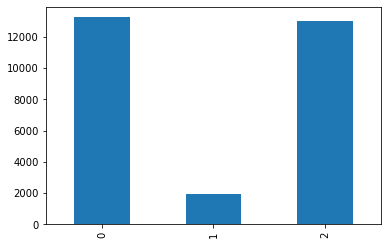

In [91]:
human['class'].value_counts().sort_index().plot.bar()

In [92]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_h, 
                                                    test_size = 0.10, 
                                                    random_state=42)

In [93]:
print(X_train.shape)
print(X_test.shape)

(25401, 272193)
(2823, 272193)


In [94]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [95]:
y_pred = classifier.predict(X_test)

In [96]:
y_pred

array([2, 0, 0, ..., 0, 2, 0], dtype=int64)

In [98]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted     0    1     2
Actual                    
0          1301    0     2
1             3  191     1
2             3    1  1321
accuracy = 0.996 
precision = 0.996 
recall = 0.996 
f1 = 0.996


In [142]:
def predict(seq):
    if type(seq)== str:
        seq = [seq]
    return classifier.predict(cv.transform(seq))

In [143]:
def find_class(seq):
    classes = ['Class_Alphaproteobacteria', 'Class_Betaproteobacteria', 'Class_Gammaproteobacteria']
    pred = predict(seq)
    return [classes[i] for i in pred]

In [145]:
predict(human_texts[0]).item()

2

In [147]:
find_class(human_texts[0:5]), find_class(human_texts[0])

(['Class_Gammaproteobacteria',
  'Class_Alphaproteobacteria',
  'Class_Gammaproteobacteria',
  'Class_Alphaproteobacteria',
  'Class_Gammaproteobacteria'],
 ['Class_Gammaproteobacteria'])

# Let's predict Order
tax = ["Class", "Order", "Family", "Genus"]

In [288]:
sg = pd.DataFrame()
for i in range(4):
    col = []
    for j in sg_reads_tax:
        if (len(j))==3:
            j.append('Simiduia')
        col.append(j[i])
    sg[tax[i]] = col

In [289]:
sg

,Class,Order,Family,Genus
0,Gammaproteobacteria,Alteromonadales,Moritellaceae,Moritella
1,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Sagittula
2,Gammaproteobacteria,"\""Vibrionales\""",Vibrionaceae,Lucibacterium
3,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Rhodobaca
4,Gammaproteobacteria,Alteromonadales,Ferrimonadaceae,Ferrimonas
...,...,...,...,...
28219,Gammaproteobacteria,Alteromonadales,Moritellaceae,Moritella
28220,Gammaproteobacteria,Oceanospirillales,Halomonadaceae,Halovibrio
28221,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Aliiroseovarius
28222,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Azorhizobium


In [290]:
print(list(sg.groupby('Order').count().index), len(sg.groupby('Order').count().index))

['Aeromonadales', 'Alteromonadales', 'Caulobacterales', 'Chromatiales', 'Ferrovales', 'Gammaproteobacteria_incertae_sedis', 'Legionellales', 'Methylophilales', 'Neisseriales', 'Oceanospirillales', 'Pasteurellales', 'Pseudomonadales', 'Rhizobiales', 'Rhodobacterales', 'Rhodospirillales', 'Sphingomonadales', 'Thiotrichales', 'Vibrionales', 'Xanthomonadales', '\\"Salinisphaerales\\"', '\\"Vibrionales\\"'] 21


In [291]:
orders = []
for i in sg['Order']:
    if i[0:2]==   r"\"":
        i = i[2:-2]
    orders.append(i)

In [292]:
sg['Order'] = orders

In [293]:
print(list(sg.groupby('Order').count().index), len(sg.groupby('Order').count().index))

['Aeromonadales', 'Alteromonadales', 'Caulobacterales', 'Chromatiales', 'Ferrovales', 'Gammaproteobacteria_incertae_sedis', 'Legionellales', 'Methylophilales', 'Neisseriales', 'Oceanospirillales', 'Pasteurellales', 'Pseudomonadales', 'Rhizobiales', 'Rhodobacterales', 'Rhodospirillales', 'Salinisphaerales', 'Sphingomonadales', 'Thiotrichales', 'Vibrionales', 'Xanthomonadales'] 20


In [206]:
pd.get_dummies(sg['Order'])

,Aeromonadales,Alteromonadales,Caulobacterales,Chromatiales,Ferrovales,Gammaproteobacteria_incertae_sedis,Legionellales,Methylophilales,Neisseriales,Oceanospirillales,Pasteurellales,Pseudomonadales,Rhizobiales,Rhodobacterales,Rhodospirillales,Salinisphaerales,Sphingomonadales,Thiotrichales,Vibrionales,Xanthomonadales
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28219,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28220,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28221,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
28222,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [220]:
orders = list(pd.get_dummies(sg['Order']).columns)
orders = ['order_' + i for i in orders]

labels_orders = np.argmax(np.array(pd.get_dummies(sg['Order'])), axis=1)
print(labels_orders, len(labels))

[ 1 13 18 ... 13 12 19] 28224


In [221]:
orders

['order_Aeromonadales',
 'order_Alteromonadales',
 'order_Caulobacterales',
 'order_Chromatiales',
 'order_Ferrovales',
 'order_Gammaproteobacteria_incertae_sedis',
 'order_Legionellales',
 'order_Methylophilales',
 'order_Neisseriales',
 'order_Oceanospirillales',
 'order_Pasteurellales',
 'order_Pseudomonadales',
 'order_Rhizobiales',
 'order_Rhodobacterales',
 'order_Rhodospirillales',
 'order_Salinisphaerales',
 'order_Sphingomonadales',
 'order_Thiotrichales',
 'order_Vibrionales',
 'order_Xanthomonadales']

In [222]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X, 
                                                    labels_orders, 
                                                    test_size = 0.10, 
                                                    random_state=42)

In [224]:
print(X_train_o.shape)
print(X_test_o.shape)

(25401, 272193)
(2823, 272193)


In [225]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB
classifier_o = MultinomialNB(alpha=0.1)
classifier_o.fit(X_train_o, y_train_o)

MultinomialNB(alpha=0.1)

In [226]:
y_pred_o = classifier_o.predict(X_test_o)
y_pred_o

array([19, 13, 13, ..., 13,  5, 13], dtype=int64)

In [227]:
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test_o, name='Actual'), pd.Series(y_pred_o, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test_o, y_pred_o)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0    1    2   3   4   5   6   7    8    9    10  11   12   13  14  \
Actual                                                                         
0          20    0    0   0   0   0   0   0    0    0    0   0    0    0   0   
1           3  306    0   1   0   2   0   0    0   11    0   8    2    0   0   
2           0    0  108   0   0   0   0   0    0    0    0   0    3    3   0   
3           0    0    0  48   0   0   0   0    0    0    0   0    0    0   0   
4           0    0    0   0  37   0   0   0    0    0    0   0    0    0   0   
5           0    4    0   0   0  23   1   0    0    1    0   0    0    0   0   
6           0    0    0   0   0   0  57   0    0    0    0   0    0    0   0   
7           0    0    0   0   0   0   0  19    1    0    0   0    0    0   0   
8           0    0    0   0   0   0   0   0  138    0    0   0    0    0   0   
9           1   12    0   0   1   1   0   0    0  306    0   2    1    0   0   
10          0    1    

In [228]:
def predict_o(seq):
    if type(seq)== str:
        seq = [seq]
    return classifier_o.predict(cv.transform(seq))

def find_order(seq):
    orders = ['order_Aeromonadales', 'order_Alteromonadales', 'order_Caulobacterales', 'order_Chromatiales',
              'order_Ferrovales', 'order_Gammaproteobacteria_incertae_sedis', 'order_Legionellales', 
              'order_Methylophilales', 'order_Neisseriales', 'order_Oceanospirillales', 'order_Pasteurellales', 
              'order_Pseudomonadales', 'order_Rhizobiales', 'order_Rhodobacterales', 'order_Rhodospirillales', 
              'order_Salinisphaerales', 'order_Sphingomonadales', 'order_Thiotrichales', 'order_Vibrionales',
              'order_Xanthomonadales']
    pred = predict_o(seq)
    return [orders[i] for i in pred]

In [231]:
predict_o(human_texts[3]).item()

13

In [234]:
find_order(human_texts[0:5])

['order_Alteromonadales',
 'order_Rhodobacterales',
 'order_Vibrionales',
 'order_Rhodobacterales',
 'order_Alteromonadales']

# Family

In [294]:
sg.head()

,Class,Order,Family,Genus
0,Gammaproteobacteria,Alteromonadales,Moritellaceae,Moritella
1,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Sagittula
2,Gammaproteobacteria,Vibrionales,Vibrionaceae,Lucibacterium
3,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Rhodobaca
4,Gammaproteobacteria,Alteromonadales,Ferrimonadaceae,Ferrimonas


In [295]:
print(list(sg.groupby('Family').count().index),'\n', len(sg.groupby('Family').count().index))

['Aeromonadaceae', 'Alteromonadaceae', 'Alteromonadales_incertae_sedis', 'Bradyrhizobiaceae', 'Brucellaceae', 'Caulobacteraceae', 'Chromatiaceae', 'Colwelliaceae', 'Coxiellaceae', 'Erythrobacteraceae', 'Ferrimonadaceae', 'Ferrovaceae', 'Hahellaceae', 'Halomonadaceae', 'Hyphomicrobiaceae', 'Hyphomonadaceae', 'Idiomarinaceae', 'Legionellaceae', 'Methylophilaceae', 'Moritellaceae', 'Neisseriaceae', 'Oceanospirillaceae', 'Oceanospirillales_incertae_sedis', 'Pasteurellaceae', 'Phyllobacteriaceae', 'Piscirickettsiaceae', 'Pseudoalteromonadaceae', 'Pseudomonadaceae', 'Psychromonadaceae', 'Rhizobiaceae', 'Rhodobacteraceae', 'Rhodospirillaceae', 'Simiduia', 'Sinobacteraceae', 'Sphingomonadaceae', 'Vibrionaceae', 'Xanthobacteraceae', 'Xanthomonadaceae', '\\"Salinisphaeraceae\\"'] 
 39


In [296]:
families = []
for i in sg['Family']:
    if i[0:2]==   r"\"":
        i = i[2:-2]
    families.append(i)

In [297]:
sg['Family'] = families

In [298]:
print(list(sg.groupby('Family').count().index), len(sg.groupby('Family').count().index))

['Aeromonadaceae', 'Alteromonadaceae', 'Alteromonadales_incertae_sedis', 'Bradyrhizobiaceae', 'Brucellaceae', 'Caulobacteraceae', 'Chromatiaceae', 'Colwelliaceae', 'Coxiellaceae', 'Erythrobacteraceae', 'Ferrimonadaceae', 'Ferrovaceae', 'Hahellaceae', 'Halomonadaceae', 'Hyphomicrobiaceae', 'Hyphomonadaceae', 'Idiomarinaceae', 'Legionellaceae', 'Methylophilaceae', 'Moritellaceae', 'Neisseriaceae', 'Oceanospirillaceae', 'Oceanospirillales_incertae_sedis', 'Pasteurellaceae', 'Phyllobacteriaceae', 'Piscirickettsiaceae', 'Pseudoalteromonadaceae', 'Pseudomonadaceae', 'Psychromonadaceae', 'Rhizobiaceae', 'Rhodobacteraceae', 'Rhodospirillaceae', 'Salinisphaeraceae', 'Simiduia', 'Sinobacteraceae', 'Sphingomonadaceae', 'Vibrionaceae', 'Xanthobacteraceae', 'Xanthomonadaceae'] 39


In [299]:
pd.get_dummies(sg['Family'])

,Aeromonadaceae,Alteromonadaceae,Alteromonadales_incertae_sedis,Bradyrhizobiaceae,Brucellaceae,Caulobacteraceae,Chromatiaceae,Colwelliaceae,Coxiellaceae,Erythrobacteraceae,...,Rhizobiaceae,Rhodobacteraceae,Rhodospirillaceae,Salinisphaeraceae,Simiduia,Sinobacteraceae,Sphingomonadaceae,Vibrionaceae,Xanthobacteraceae,Xanthomonadaceae
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28221,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
28222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [307]:
families = list(pd.get_dummies(sg['Family']).columns)
families = ['familiy_' + i for i in families]

labels_families = np.argmax(np.array(pd.get_dummies(sg['Family'])), axis=1)
print(labels_families, len(labels_families))

[19 30 36 ... 30 37 38] 28224


In [308]:
len(families)

39

In [310]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, 
                                                    labels_families, 
                                                    test_size = 0.10, 
                                                    random_state=42)

In [311]:
print(X_train_f.shape)
print(X_test_f.shape)

(25401, 272193)
(2823, 272193)


In [318]:
max(y_train_f), max(y_test_f)

(38, 38)

In [312]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB
classifier_f = MultinomialNB(alpha=0.1)
classifier_f.fit(X_train_f, y_train_f)

MultinomialNB(alpha=0.1)

In [319]:
y_pred_f = classifier_f.predict(X_test_f)
y_pred_f

array([38, 30, 30, ..., 30, 33, 30], dtype=int64)

In [320]:
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test_f, name='Actual'), pd.Series(y_pred_f, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test_f, y_pred_f)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0    1   2   3   4   5   6   7   8   9   ...  29   30  31  32  33  \
Actual                                              ...                        
0          20    0   0   0   0   0   0   0   0   0  ...   0    0   0   0   0   
1           0  106   1   0   0   0   0   0   0   0  ...   0    0   0   1   1   
2           0    0  29   0   0   0   0   0   0   0  ...   0    0   0   0   1   
3           0    0   0  76   0   0   0   0   0   0  ...   0    0   0   0   0   
4           0    0   0   0  28   0   0   0   0   0  ...   0    0   0   0   0   
5           0    0   0   0   0  61   0   0   0   0  ...   0    0   0   0   0   
6           0    0   0   0   0   0  48   0   0   0  ...   0    0   0   0   0   
7           0    0   0   0   0   0   0  28   0   0  ...   0    0   0   0   0   
8           0    0   0   0   0   0   0   0  30   0  ...   0    0   0   0   0   
9           0    0   0   0   0   0   0   0   0  52  ...   0    0   0   0   0   
10          0    0   0

In [323]:
def predict_f(seq):
    if type(seq)== str:
        seq = [seq]
    return classifier_f.predict(cv.transform(seq))

def find_family(seq):
    pred = predict_f(seq)
    return [families[i] for i in pred]

In [324]:
predict_f(human_texts[3]).item()

30

In [325]:
find_family(human_texts[0:5])

['familiy_Moritellaceae',
 'familiy_Rhodobacteraceae',
 'familiy_Vibrionaceae',
 'familiy_Rhodobacteraceae',
 'familiy_Ferrimonadaceae']

# GENUS

In [334]:
sg.head()

,Class,Order,Family,Genus
0,Gammaproteobacteria,Alteromonadales,Moritellaceae,Moritella
1,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Sagittula
2,Gammaproteobacteria,Vibrionales,Vibrionaceae,Lucibacterium
3,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Rhodobaca
4,Gammaproteobacteria,Alteromonadales,Ferrimonadaceae,Ferrimonas


In [335]:
print(list(sg.groupby('Genus').count().index),'\n', len(sg.groupby('Genus').count().index))

['Actinobacillus', 'Afipia', 'Agarivorans', 'Aggregatibacter', 'Algimonas', 'Aliidiomarina', 'Aliiroseovarius', 'Allochromatium', 'Alteromonas', 'Amphritea', 'Amylibacter', 'Ancylobacter', 'Aquaspirillum', 'Azorhizobium', 'Brevundimonas', 'Caulobacter', 'Celeribacter', 'Cellvibrio', 'Chelonobacter', 'Chitinibacter', 'Chromohalobacter', 'Cobetia', 'Coxiella', 'Croceicoccus', 'Erythrobacter', 'Falsochrobactrum', 'Ferrimonas', 'Ferrovum', 'Hahella', 'Halovibrio', 'Henriciella', 'Histophilus', 'Kingella', 'Labrys', 'Legionella', 'Leisingera', 'Loktanella', 'Lucibacterium', 'Luteibacter', 'Marinobacter', 'Marinomonas', 'Marinospirillum', 'Maritalea', 'Marivita', 'Mesorhizobium', 'Methylobacillus', 'Moritella', 'Nautella', 'Necropsobacter', 'Neisseria', 'Neorhizobium', 'Nevskia', 'Nicoletella', 'Nitrincola', 'Nitrosococcus', 'Niveispirillum', 'Novispirillum', 'Oceanisphaera', 'Pannonibacter', 'Paraglaciecola', 'Pedomicrobium', 'Pelagibacterium', 'Pelagibius', 'Phaeobacter', 'Phocoenobacter',

In [336]:
pd.get_dummies(sg['Genus'])

,Actinobacillus,Afipia,Agarivorans,Aggregatibacter,Algimonas,Aliidiomarina,Aliiroseovarius,Allochromatium,Alteromonas,Amphritea,...,Sphingosinicella,Starkeya,Stenotrophomonas,Tardiphaga,Teredinibacter,Thalassotalea,Thermomonas,Thioalkalimicrobium,Xanthobacter,Zymobacter
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28221,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [340]:
genes = list(pd.get_dummies(sg['Genus']).columns)
genes = ['genus_' + i for i in genes]

labels_genes = np.argmax(np.array(pd.get_dummies(sg['Genus'])), axis=1)
print(labels_genes, len(labels_genes))

[46 82 37 ...  6 13 92] 28224


In [343]:
print(genes)
len(genes)

['genus_Actinobacillus', 'genus_Afipia', 'genus_Agarivorans', 'genus_Aggregatibacter', 'genus_Algimonas', 'genus_Aliidiomarina', 'genus_Aliiroseovarius', 'genus_Allochromatium', 'genus_Alteromonas', 'genus_Amphritea', 'genus_Amylibacter', 'genus_Ancylobacter', 'genus_Aquaspirillum', 'genus_Azorhizobium', 'genus_Brevundimonas', 'genus_Caulobacter', 'genus_Celeribacter', 'genus_Cellvibrio', 'genus_Chelonobacter', 'genus_Chitinibacter', 'genus_Chromohalobacter', 'genus_Cobetia', 'genus_Coxiella', 'genus_Croceicoccus', 'genus_Erythrobacter', 'genus_Falsochrobactrum', 'genus_Ferrimonas', 'genus_Ferrovum', 'genus_Hahella', 'genus_Halovibrio', 'genus_Henriciella', 'genus_Histophilus', 'genus_Kingella', 'genus_Labrys', 'genus_Legionella', 'genus_Leisingera', 'genus_Loktanella', 'genus_Lucibacterium', 'genus_Luteibacter', 'genus_Marinobacter', 'genus_Marinomonas', 'genus_Marinospirillum', 'genus_Maritalea', 'genus_Marivita', 'genus_Mesorhizobium', 'genus_Methylobacillus', 'genus_Moritella', 'ge

100

In [344]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X, 
                                                    labels_genes, 
                                                    test_size = 0.10, 
                                                    random_state=42)

In [345]:
print(X_train_g.shape)
print(X_test_g.shape)

(25401, 272193)
(2823, 272193)


In [346]:
max(y_train_g), max(y_test_g)

(99, 99)

In [347]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB
classifier_g = MultinomialNB(alpha=0.1)
classifier_g.fit(X_train_g, y_train_g)

MultinomialNB(alpha=0.1)

In [348]:
y_pred_g = classifier_g.predict(X_test_g)
y_pred_g

array([96, 67, 10, ..., 47, 87, 69], dtype=int64)

In [349]:
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test_g, name='Actual'), pd.Series(y_pred_g, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test_g, y_pred_g)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0   1   2   3   4   5   6   7   8   9   ...  90  91  92  93  94  \
Actual                                             ...                       
0          15   0   0   2   0   0   0   0   0   0  ...   0   0   0   0   0   
1           0  14   0   0   0   0   0   0   0   0  ...   0   0   0   1   0   
2           0   0  26   0   0   0   0   0   0   0  ...   0   0   0   0   0   
3           0   0   0  36   0   0   0   0   0   0  ...   0   0   0   0   0   
4           0   0   0   0  29   0   0   0   0   0  ...   0   0   0   0   0   
...        ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..   
95          0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
96          0   0   0   0   0   0   0   0   0   0  ...   0   0   4   0   0   
97          0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   0   
98          0   0   0   0   0   0   0   0   0   0  ...   0   2   0   0   0   
99          0   0   0   0   0   0   0   0   0 

In [350]:
def predict_g(seq):
    if type(seq)== str:
        seq = [seq]
    return classifier_g.predict(cv.transform(seq))

def find_genus(seq):
    pred = predict_g(seq)
    return [genes[i] for i in pred]

In [351]:
predict_g(human_texts[3]).item()

77

In [353]:
find_genus(human_texts[0:5])

['genus_Moritella',
 'genus_Sagittula',
 'genus_Lucibacterium',
 'genus_Rhodobaca',
 'genus_Ferrimonas']